Epoch 1/50
391/391 [==============================] - 42s 43ms/step - loss: 0.7799 - accuracy: 0.6774 - val_loss: 0.7024 - val_accuracy: 0.5537
Epoch 2/50
391/391 [==============================] - 6s 15ms/step - loss: 0.3153 - accuracy: 0.8696 - val_loss: 0.2700 - val_accuracy: 0.8772
Epoch 3/50
391/391 [==============================] - 6s 15ms/step - loss: 0.1852 - accuracy: 0.9329 - val_loss: 0.1636 - val_accuracy: 0.9207
Epoch 4/50
391/391 [==============================] - 6s 15ms/step - loss: 0.1404 - accuracy: 0.9465 - val_loss: 0.0996 - val_accuracy: 0.9706
Epoch 5/50
391/391 [==============================] - 6s 16ms/step - loss: 0.1139 - accuracy: 0.9601 - val_loss: 0.3504 - val_accuracy: 0.8632
Epoch 6/50
391/391 [==============================] - 6s 15ms/step - loss: 0.1128 - accuracy: 0.9533 - val_loss: 0.0772 - val_accuracy: 0.9731
Epoch 7/50
391/391 [==============================] - 6s 15ms/step - loss: 0.0885 - accuracy: 0.9743 - val_loss: 0.1082 - val_accuracy: 0.959

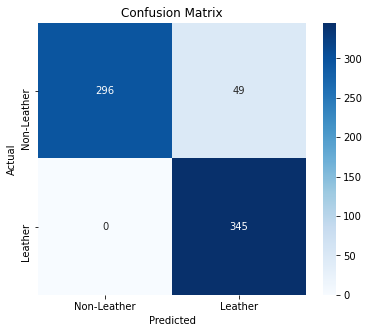

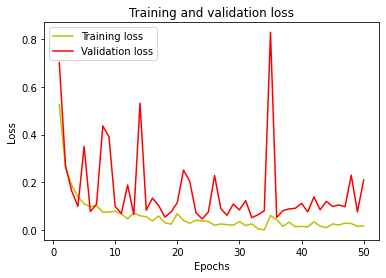

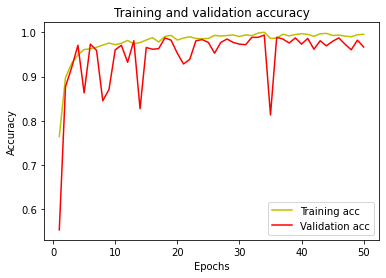

In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import time

def load_dataset(foldername, label, width=227, height=227):
    image_files = os.listdir(foldername)
    images = []
    for image in image_files:
        img_path = os.path.join(foldername, image)
        img = Image.open(img_path).convert("RGB")
        img = np.array(img.resize((width, height)))
        images.append(img)

    labels = np.array([label] * len(images))
    return np.array(images) / 255.0, labels

# Load Leather and Non-Leather datasets
leather_folder = '/mnt/Project-2/Leather image datasets/CS_4600/leather'
non_leather_folder = '/mnt/Project-2/Leather image datasets/CS_4600/nonleather'

X_leather, y_leather = load_dataset(leather_folder, 1)
X_non_leather, y_non_leather = load_dataset(non_leather_folder, 0)

# Split 345 images for testing
X_test_leather = X_leather[:345]
y_test_leather = y_leather[:345]
X_test_non_leather = X_non_leather[:345]
y_test_non_leather = y_non_leather[:345]

X_leather = X_leather[345:]
y_leather = y_leather[345:]
X_non_leather = X_non_leather[345:]
y_non_leather = y_non_leather[345:]

# Create test and training datasets
X_test = np.concatenate((X_test_leather, X_test_non_leather), axis=0)
y_test = np.concatenate((y_test_leather, y_test_non_leather), axis=0)

X = np.concatenate((X_leather, X_non_leather), axis=0)
y = np.concatenate((y_leather, y_non_leather), axis=0)

# Shuffle data
X, y = shuffle(X, y, random_state=42)
y = tf.keras.utils.to_categorical(y, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define AlexNet Model
def AlexNet(input_shape=(227, 227, 3), num_labels=2):
    model = Sequential()
    model.add(layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))
    model.add(layers.Conv2D(256, (5, 5), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))
    model.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_labels, activation='softmax'))
    return model

# Create and compile the model
alex_net = AlexNet()

alex_net.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

# Measure Latency and Throughput
start_time = time.time()

history = alex_net.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=8,
    verbose=1
)

end_time = time.time()
latency = (end_time - start_time) / len(X_train)
throughput = len(X_train) / (end_time - start_time)

# Evaluate Model
test_loss, test_acc = alex_net.evaluate(X_test, y_test, verbose=1)

# Print Latency and Throughput results
print(f"Latency (per batch): {latency:.4f} seconds")
print(f"Throughput: {throughput:.4f} samples per second")

# Average Training & Validation Metrics
avg_train_acc = np.mean(history.history['accuracy'])
avg_val_acc = np.mean(history.history['val_accuracy'])
avg_train_loss = np.mean(history.history['loss'])
avg_val_loss = np.mean(history.history['val_loss'])

print(f"Average Training Accuracy: {avg_train_acc:.4f}")
print(f"Average Validation Accuracy: {avg_val_acc:.4f}")
print(f"Average Training Loss: {avg_train_loss:.4f}")
print(f"Average Validation Loss: {avg_val_loss:.4f}")

# Test Accuracy
print(f"Test Accuracy: {test_acc:.4f}")

# Save the trained model 
alex_net.save('Alexnet_cs4600.h5')
print("Model saved as 'Alexnet_cs4600.h5'")

# Confusion Matrix
y_pred_probs = alex_net.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Leather", "Leather"], yticklabels=["Non-Leather", "Leather"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Plot Loss curves
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
